In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import io
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
  
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

from typing import List
from masks import ring_mask, box_mask, dot_mask
from load_compression_models import (
    my_bmshj2018_factorized, 
    my_bmshj2018_factorized_relu,
    my_bmshj2018_hyperprior,
    my_cheng2020_anchor,
    my_cheng2020_attn,
    my_mbt2018,
    my_mbt2018_mean
)

### Load the Compression Networks

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'

In [3]:
models = {
    'my_bmshj2018_factorized_relu': my_bmshj2018_factorized_relu(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_factorized'     : my_bmshj2018_factorized(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_hyperprior'     : my_bmshj2018_hyperprior(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_anchor'         : my_cheng2020_anchor(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_attn'           : my_cheng2020_attn(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018'                  : my_mbt2018(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018_mean'             : my_mbt2018_mean(quality=2, pretrained=True).to(torch.float32).train().to(device)
}
net = models['my_bmshj2018_factorized_relu']
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Load the Dataset

In [4]:
# Define the transformations
img_WH = 256
transform = transforms.Compose([
    transforms.Resize((img_WH, img_WH)),
    transforms.ToTensor(),
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Files already downloaded and verified


### Run Attack

In [5]:
class StatsMeter:
    # Utility function to track statistics of a variable
    # over time
    def __init__(self) -> None:
        self.data = []
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0
        self.min = float('inf')

    def update(self, val : float, n : int = 1) -> None:
        self.count += n
        self.data.append(val)
        self.sum = sum(self.data)
        self.avg = self.sum / len(self.data)
        self.max = max(self.data)
        self.min = min(self.data)

In [6]:
x = dataset[0][0].unsqueeze(0).to(device)

num_sources = 4
x_hat = [] #dataset[1][0].unsqueeze(0).to(device)
for i, (images, label) in enumerate(dataloader):
    # num sources must be less than batch size
    x_hat = images[:num_sources].to(device)
    break

x_src = x_hat.clone()
x_hat.requires_grad = True

In [7]:
def pgd(
        src_img: torch.Tensor, 
        target_img: torch.Tensor, 
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        scheduler: torch.optim.lr_scheduler.LRScheduler, 
        num_steps: int, 
        mask: torch.Tensor = None
    ) -> List:
    # Move images to the same device as the model
    src_img = src_img.to(device)
    target_img = target_img.to(device)
    mask = mask.to(device)
    # Get the embedding of the source image and make a copy of the target
    src_emb = model.forward(src_img)['y_hat']

    # Track the best performance
    best_img = None
    loss_tracker = StatsMeter()

    pbar = tqdm(range(num_steps))
    for _ in pbar:  
        out = model.forward(target_img)
        target_emb = out['y_hat']
        loss = F.mse_loss(src_emb, target_emb)
        pbar.set_description(f"[Running attack]: Loss {loss.item():.5f}")

        optimizer.zero_grad()
        target_img.grad,  = torch.autograd.grad(loss, [target_img])
        # loss.backward(retain_graph=True)
        if mask is not None:
            target_img.grad *= mask
        optimizer.step()
        scheduler.step()
        loss_tracker.update(loss.item())

        # Save the image that achieved the best performance
        if loss.item() == loss_tracker.min:
            best_img = target_img

    return best_img, loss_tracker

In [8]:
# Set hyperparams for mask generation and PGD itself
num_steps = 2500
mask_type = 'dot'
if mask_type == 'box':
    lr = 3e-3
    mask = box_mask()
elif mask_type == 'ring':
    lr = 3e-3
    num_rings = 50
    ring_width = 1
    ring_separation = 5
    mask = ring_mask(x_hat, num_rings=num_rings, ring_width=ring_width, ring_separation=ring_separation)
elif mask_type == 'dot':
    lr = 3e-2
    vertical_skip = 3
    horizontal_skip = 3
    mask = dot_mask(x_hat, vertical_skip=vertical_skip, horizontal_skip=horizontal_skip)

# Run the attack and produce an adversarial image y_hat
optimizer = torch.optim.Adam([x_hat], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
x_adv, loss_tracker = pgd(x, x_hat, model=net, optimizer=optimizer, scheduler=scheduler, num_steps=num_steps, mask=mask)
# Pass the adv image through the compression network and see the result
output = net.forward(x_adv)['x_hat']

[Running attack]: Loss 0.16331: 100%|██████████| 2500/2500 [00:25<00:00, 99.80it/s] 


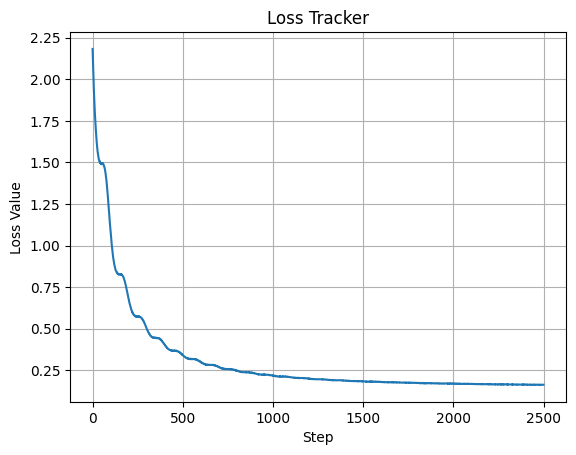

In [9]:
# Show how the loss changed during optimization
plt.plot(loss_tracker.data)
plt.xlabel('Step')
plt.ylabel('Loss Value')
plt.title('Loss Tracker')
plt.grid()
plt.show()

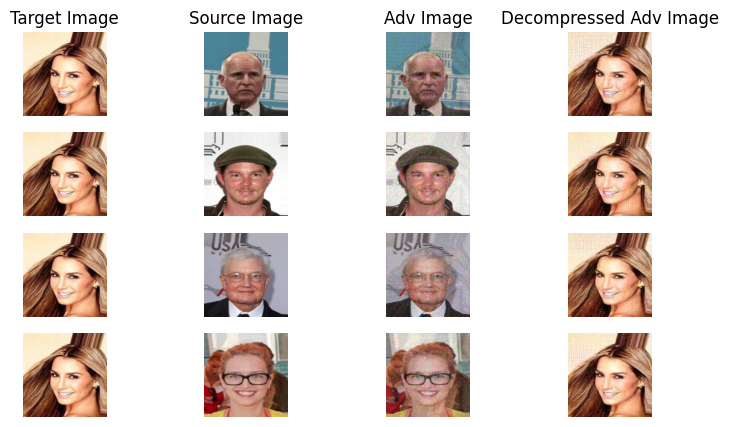

In [10]:
# Create a figure to hold the subplots
fig, axs = plt.subplots(num_sources, 4, figsize=(9, 5))  # num_sources rows, 4 columns
labels = ['Target Image', 'Source Image', 'Adv Image', 'Decompressed Adv Image']

for idx in range(num_sources):
    images = [x, x_src[idx], x_adv[idx], output[idx]]
    
    # Iterate over the images and axes to plot each image
    for img_idx, ax in enumerate(axs[idx] if num_sources > 1 else axs):  # Use idx for outer loop, img_idx for inner
        img = images[img_idx].clip(0, 1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Change the shape to [H, W, C]
        ax.imshow(img)
        if idx == 0:
            ax.set_title(labels[img_idx])
        ax.axis('off')  # Hide axis

plt.show()

### Performance Metrics

Similarity between the adversarial output of the network and the target image

In [11]:
def calculate_psnr(img1, img2, max_val=1.0):
    # img1 and img2 should be of shape (batch_size, channels, height, width) and normalized to [0, 1] range
    mse = F.mse_loss(img1, img2)
    psnr = 10 * torch.log10(max_val / torch.sqrt(mse))
    return psnr

In [12]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(num_sources):
    normalized_l2_dist.append(torch.norm(x - output[i]) / (3 * img_WH * img_WH))
    struct_sim.append(ssim(x, output[i].unsqueeze(0)))
    psnr.append(calculate_psnr(x, output[i]))

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 0.00011584828462218866
SSIM: 0.9998781085014343
PSNR: 12.893802642822266


Similarity between the source image and the adversarial image

In [13]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(num_sources):
    normalized_l2_dist = torch.norm(x_src[i] - x_adv[i]) / (3 * img_WH * img_WH)
    struct_sim = ssim(x_src[i].unsqueeze(0), x_adv[i].unsqueeze(0))
    psnr = calculate_psnr(x_src[i], x_adv[i])

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 0.0037734652869403362
SSIM: 0.9376875758171082
PSNR: -2.2354092597961426
